### EE 421/521 Image Processing

## Project 6 - Color Theory


In this project, you will implement the following:

1. Extract the YUV bands of an image
2. Decimate the Y band and show its effect on the quality of the RGB image
3. Decimate the U band and show its effect on the quality of the RGB image
4. Decimate the V band and show its effect on the quality of the RGB image

**Note: This project will be graded for both EE 421 (HW5) and EE 521 (HW5) students.**

*Copyright (c) 2020-2022 by Arif Tanju Erdem*

In [80]:
# import necessary packages

# reading/writing image files
from skimage import io
from skimage import color

# displaying images and plots
import matplotlib.pyplot as plt

# array operations
import numpy as np

# mathematical calculations
import math
import cmath

# DFT calculations
from scipy import fftpack as ft

# histogram calculation
from skimage import exposure

# signal processing operations
from scipy import signal
from scipy.linalg import circulant

# Mount Google Drive folder to Colab
from google.colab import drive
drive.mount('/content/drive',force_remount = True)


Mounted at /content/drive


In [81]:
# display an image in original size

def my_display_actual_size(img, str_caption):

    height = img.shape[0]
    width = img.shape[1]
    ndim = img.ndim

    isColor = True
    if ndim == 1: isColor=False
    elif ndim != 3: assert False

    # determine a figure size big enough to accomodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc.
    margin = 0.05
    dpi = 80
    figsize = (1.0+margin)*height/dpi, (1.0+margin)*width/dpi

    # define the figure
    fig = plt.figure(figsize=figsize, dpi=dpi)

    # make the axis the right size
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    # display the image
    if isColor:
        ax.imshow(img, interpolation='none')
    else:
        ax.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')
    plt.title(str_caption)
    plt.show()

    return

# end of function

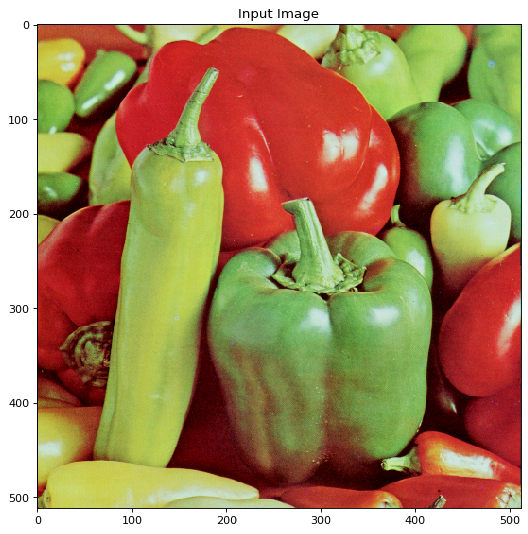

In [82]:
# STEP 0 Pick an image

# set image folder
image_folder = r'/content/drive/MyDrive/Colab Notebooks/EE421/images'

# read input image
image_file = r'/peppers.png'
image_path = image_folder + image_file
imgRGB = io.imread(image_path)

# display image
my_display_actual_size(imgRGB,'Input Image')

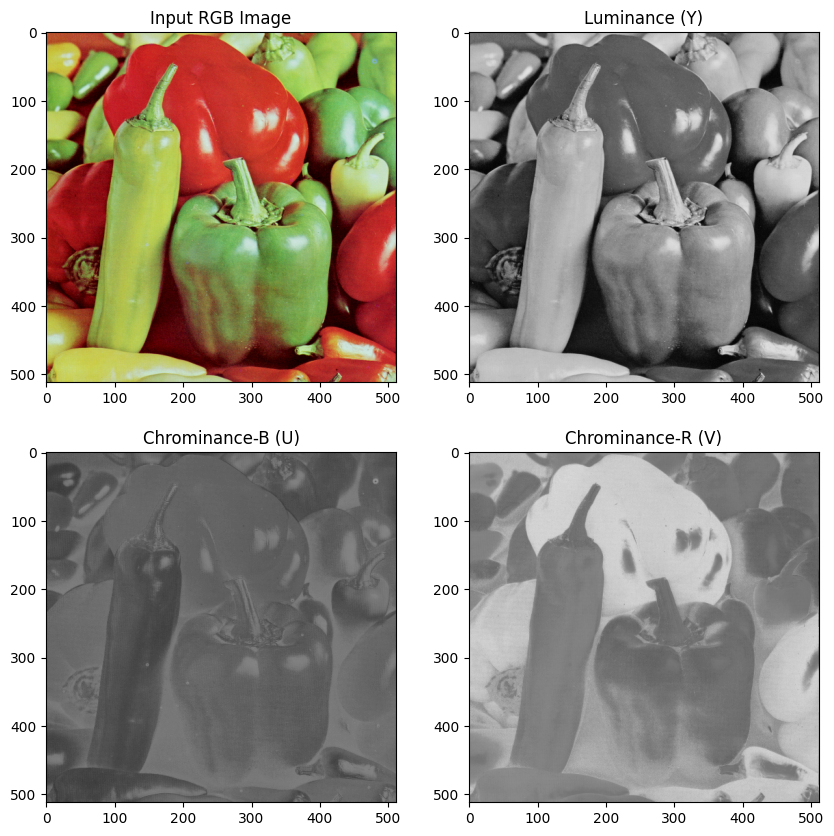

In [83]:
# STEP 1 Transform the image into YUV color space
# calculate RMSE
def my_RMSE(img1, img2):

    assert img1.ndim == img2.ndim
    assert img1.size == img2.size

    return math.sqrt(((img1 - img2) ** 2).sum() / img1.size)

#---------------------------------------------------------------
# Extract the YUV bands of the image using "my_RGB2YUV()" function
#---------------------------------------------------------------

def my_RGB2YUV(imgRGB):

    N, M, D = imgRGB.shape

    assert N > 0
    assert M > 0
    assert D == 3

    # RGB to YUV conversion matrix
    rgb2yuv = np.array([[0.299,    0.587,    0.114   ],
                       [-0.168736, -0.331264,  0.5   ],
                       [ 0.5,   -0.418688, -0.081312]])

    # convert from RGB to YUV
    imgYUV = np.dot(imgRGB, np.transpose(rgb2yuv))

    # add 128 to U and V bands
    imgYUV[:,:,1] += 128.0
    imgYUV[:,:,2] += 128.0

    return imgYUV

imgYUV = my_RGB2YUV(imgRGB)# Convert to YUV
my_Y = imgYUV[:, :, 0]
my_U = imgYUV[:, :, 1]
my_V = imgYUV[:, :, 2]

plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(imgRGB)
plt.title('Input RGB Image')
plt.subplot(222), plt.imshow(my_Y, cmap='gray', vmin=0, vmax=255)
plt.title('Luminance (Y)')
plt.subplot(223), plt.imshow(my_U, cmap='gray', vmin=0, vmax=255)
plt.title('Chrominance-B (U)')
plt.subplot(224), plt.imshow(my_V, cmap='gray', vmin=0, vmax=255)
plt.title('Chrominance-R (V)')
plt.show()
plt.close()


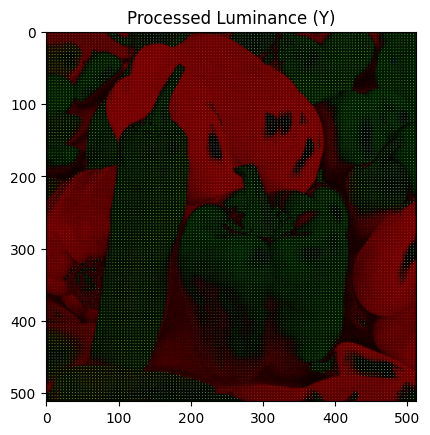

RMSE after processing the Y band: 9.97183310606423


In [84]:
# STEP 2.a Demonstrate the effect of the Y band on image resolution

#---------------------------------------------------------------
# Decimate the Y band by a factor of 4 in horizontal and vertical directions
#---------------------------------------------------------------

decimation_factor = 4
Y_decimated = my_Y[::decimation_factor, ::decimation_factor]

#---------------------------------------------------------------
# Interpolate the decimated Y band back to its original size
#---------------------------------------------------------------

Y_interpolated = np.zeros_like(my_Y)
Y_interpolated[::decimation_factor, ::decimation_factor] = Y_decimated

#---------------------------------------------------------------
# Convert from YUV back to RGB (use the processed Y band)
#---------------------------------------------------------------

def my_YUV2RGB(imgYUV):
    N, M, D = imgYUV.shape

    assert N > 0
    assert M > 0
    assert D == 3

    yuv2rgb = np.array([[1.0,  0.0,        1.402],
                        [1.0, -0.344136, -0.714136],
                        [1.0,  1.772,      0.0]])

    imgYUV[:,:,1] -= 128.0
    imgYUV[:,:,2] -= 128.0

    imgRGB = np.dot(imgYUV, np.transpose(yuv2rgb))
    imgRGB = np.clip(imgRGB, 0, 255)

    return imgRGB.astype(np.uint8)

imgRGB_processed_Y = my_YUV2RGB(np.dstack((Y_interpolated, imgYUV[:,:,1], imgYUV[:,:,2])))
plt.imshow(imgRGB_processed_Y)
plt.title('Processed Luminance (Y)')
plt.show()
#---------------------------------------------------------------
# Calculate and print the RMSE between the above image and the original image
#---------------------------------------------------------------

rmse = my_RMSE(imgRGB, imgRGB_processed_Y)
print("RMSE after processing the Y band:", rmse)



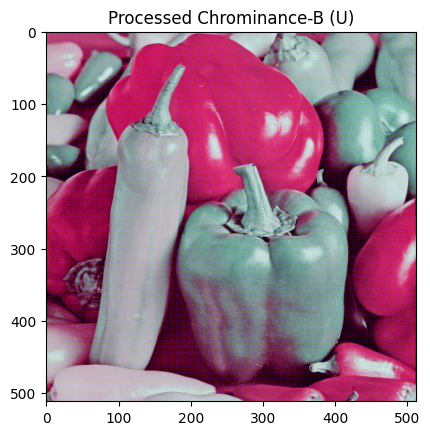

RMSE after processing the U band:  8.49585084063672


In [85]:
# STEP 2.b Demonstrate the effect of the U band on image resolution

#---------------------------------------------------------------
# Decimate the U band by a factor of 4 in horizontal and vertical directions
#---------------------------------------------------------------

decimation_factor = 4
U_decimated = my_U[::decimation_factor, ::decimation_factor]

#---------------------------------------------------------------
# Interpolate the decimated U band back to its original size
#---------------------------------------------------------------

U_interpolated = np.zeros_like(my_U)
U_interpolated[::decimation_factor, ::decimation_factor] = U_decimated

#---------------------------------------------------------------
# Convert from YUV back to RGB (use the processed U band)
#---------------------------------------------------------------

def my_YUV2RGB_with_processed_U(imgYUV, processed_u):
    N, M, D = imgYUV.shape

    assert N > 0
    assert M > 0
    assert D == 3

    yuv2rgb = np.array([[1.0,  0.0,        1.402],
                        [1.0, -0.344136, -0.714136],
                        [1.0,  1.772,      0.0]])

    imgYUV[:,:,1] = processed_u
    imgYUV[:,:,2] -= 128.0

    imgRGB = np.dot(imgYUV, np.transpose(yuv2rgb))
    imgRGB = np.clip(imgRGB, 0, 255)

    return imgRGB.astype(np.uint8)

imgRGB_processed_U = my_YUV2RGB_with_processed_U(imgYUV.copy(), U_interpolated)

plt.imshow(imgRGB_processed_U)
plt.title('Processed Chrominance-B (U)')
plt.show()

#---------------------------------------------------------------
# Calculate and print the RMSE between the above image and the original image
#---------------------------------------------------------------

rmse = my_RMSE(imgRGB, imgRGB_processed_U)
print("RMSE after processing the U band: ", rmse)

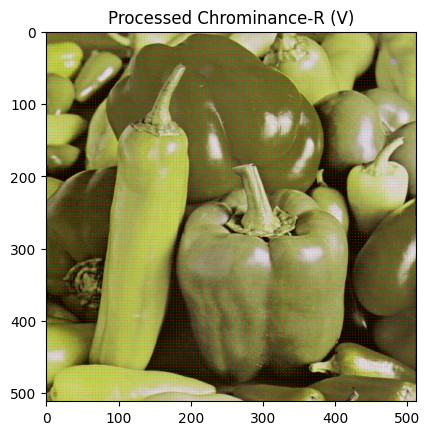

RMSE after processing the V band:  7.945642735142828


In [86]:
# STEP 2.c Demonstrate the effect of the V band on image resolution

#---------------------------------------------------------------
# Decimate the V band by a factor of 4 in horizontal and vertical directions
#---------------------------------------------------------------

decimation_factor = 4
V_decimated = my_V[::decimation_factor, ::decimation_factor]

#---------------------------------------------------------------
# Interpolate the decimated V band back to its original size
#---------------------------------------------------------------

V_interpolated = np.zeros_like(my_V)
V_interpolated[::decimation_factor, ::decimation_factor] = V_decimated

#---------------------------------------------------------------
# Convert from YUV back to RGB (use the processed V band)
#---------------------------------------------------------------

def my_YUV2RGB_with_processed_V(imgYUV, processed_v):
    N, M, D = imgYUV.shape

    assert N > 0
    assert M > 0
    assert D == 3


    yuv2rgb = np.array([[1.0,  0.0,        1.402],
                        [1.0, -0.344136, -0.714136],
                        [1.0,  1.772,      0.0]])

    imgYUV[:,:,1] -= 128.0
    imgYUV[:,:,2] = processed_v

    imgRGB = np.dot(imgYUV, np.transpose(yuv2rgb))
    imgRGB = np.clip(imgRGB, 0, 255)

    return imgRGB.astype(np.uint8)


imgRGB_processed_V = my_YUV2RGB_with_processed_V(imgYUV.copy(), V_interpolated)

plt.imshow(imgRGB_processed_V)
plt.title('Processed Chrominance-R (V)')
plt.show()
#---------------------------------------------------------------
# Calculate and print the RMSE between the above image and the original image
#---------------------------------------------------------------

rmse = my_RMSE(imgRGB, imgRGB_processed_V)
print("RMSE after processing the V band: ", rmse)


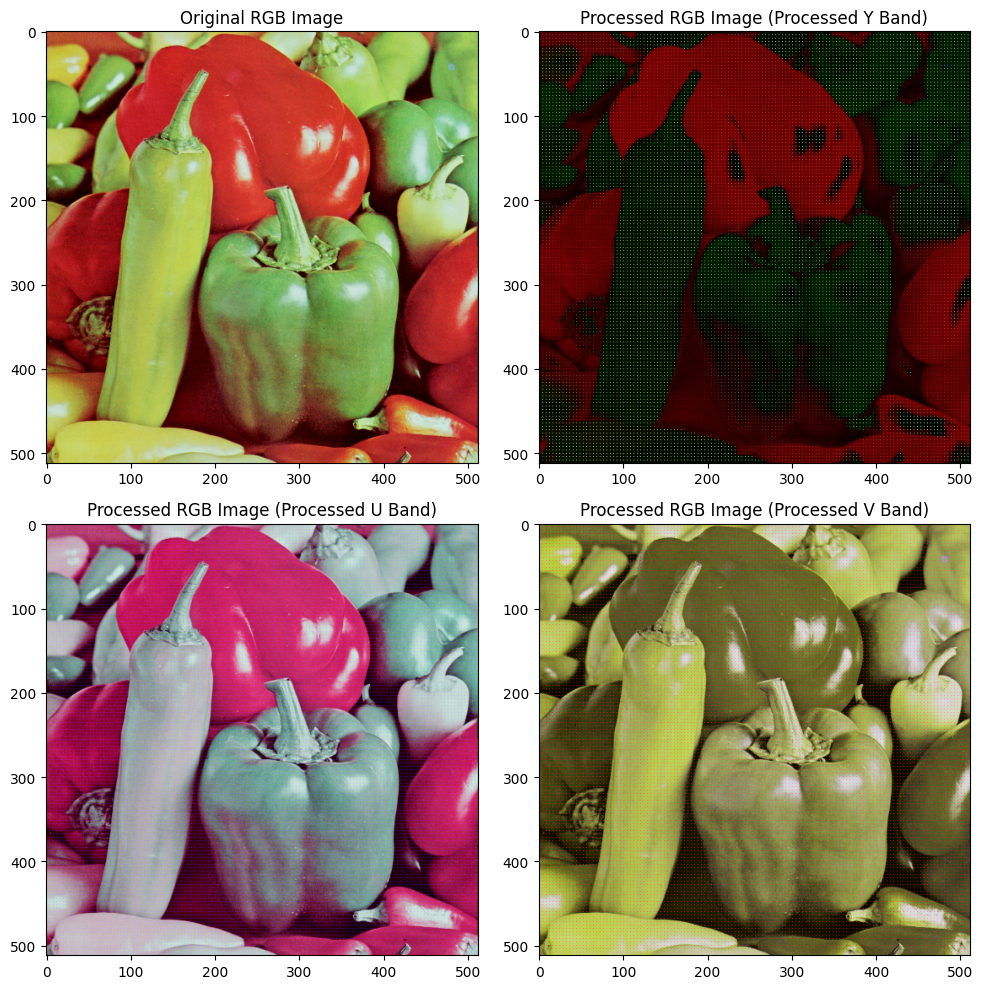

In [87]:
# STEP 3 Display the images obtained in STEP 2 above together with the original image

#---------------------------------------------------------------
# Display the original RGB image and the three RGB images obtained above in a 2x2 grid:
# [Original RGB]     [Y decimated RGB]
# [U decimated RGB]  [V decimated RGB]
#---------------------------------------------------------------

plt.figure(figsize=(10, 10))

# Original RGB image
plt.subplot(221)
plt.imshow(imgRGB)
plt.title('Original RGB Image')

# Processed Y band image
plt.subplot(222)
plt.imshow(imgRGB_processed_Y)
plt.title('Processed RGB Image (Processed Y Band)')

# Processed U band image
plt.subplot(223)
plt.imshow(imgRGB_processed_U)
plt.title('Processed RGB Image (Processed U Band)')

# Processed V band image
plt.subplot(224)
plt.imshow(imgRGB_processed_V)
plt.title('Processed RGB Image (Processed V Band)')

plt.tight_layout()
plt.show()


*STEP 4 Comments on the results*

*ADD YOUR COMMENTS HERE*

Compare the three RGB images obtained in STEP 2 to the original RGB image in terms of (a) visual quality and (b) RMSE value and explain why decimation of different YUV bands have different effects on the RGB image quality.

Original RGB image has a better visual quality compared to the Y U and V images because original image is basically a combination them.

U and V has a similar effect on RGB image quality. Decimating these components causes color artifacts in the reconstructed RGB image. However, the impact may be less pronounced compared to decimating the luminance component, as our eyes are less sensitive to color detail. Most of the details are belongs to Y (luminance) component. Therfore, decimating the  effects sharpness, brightness and clarity of the image.



In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [90]:
!jupyter nbconvert --to pdf '/content/drive/My Drive/Colab Notebooks/Prj06_ColorTheory.ipynb'

[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/Prj06_ColorTheory.ipynb to pdf
[NbConvertApp] Support files will be in Prj06_ColorTheory_files/
[NbConvertApp] Making directory ./Prj06_ColorTheory_files
[NbConvertApp] Making directory ./Prj06_ColorTheory_files
[NbConvertApp] Making directory ./Prj06_ColorTheory_files
[NbConvertApp] Making directory ./Prj06_ColorTheory_files
[NbConvertApp] Making directory ./Prj06_ColorTheory_files
[NbConvertApp] Making directory ./Prj06_ColorTheory_files
[NbConvertApp] Writing 61465 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 3384031 bytes to /content/drive/My Drive/Colab Notebooks/Prj06_ColorTheory.pdf
